# Notebook Description

This notebook is concerned with the linear regression of the number of days in each of the MJO subphases with the number of raindays each wet season and the total amount of rainfall. This is showing the relatinship between the increasing trend of days in MJO phases 5 and 6 and the increasing rainfal trend in the north west.

**Data**

The data used in this notebook is the AWAP data set and also measurement of the RMM from BOM.

# Packages

In [60]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.array
import cartopy.crs as ccrs
import matplotlib.colors as colors
import datetime as dt
from matplotlib.colors import BoundaryNorm
rb = plt.cm.RdBu
bm = plt.cm.Blues
best_blue = '#9bc2d5'
recherche_red = '#fbc4aa'
wondeful_white = '#f8f8f7'
import glob
import pdb

import warnings
warnings.filterwarnings('ignore')

import matplotlib.gridspec as gridspec

import matplotlib.patches as patch
import matplotlib.colors as mpc
import miscellaneous as misc


import sys
sys.path.append('../functions/')
# import trend_functions_2 as tf2

import load_dataset as load
from importlib import reload
import phase_calc_functions as phase_calc

import phase_plot_functions as phase_plot

import subphase_calc_functions as subphase_calc

from miscellaneous import apply_masks

# Data

In [61]:
# Loading awap
awap = load.load_awap()

# Loading RMM
rmm = load.load_rmm()

# Making sure the two are the same length
awap = awap.where(awap.time.isin(rmm.time.values), drop = True)
rmm = rmm.where(rmm.time.isin(awap.time.values), drop = True)
print('AWAP length: {}      RMM length: {} '.format(len(awap.time.values), len(rmm.time.values)))

AWAP length: 7876      RMM length: 7876 


# Wet-Season Calibration

Readjusting the years, so when a resample takes plact, it is just the data for one wet season. If 
this was not done it would be the end half of one wet season and the start of another. This moves that data
from the start of the wet season back or forwards a year (I don't remember), so that they line up

In [62]:
phase_calc = reload(phase_calc)
awap_ws = phase_calc.wet_season_year(awap)

rmm_ws = phase_calc.wet_season_year(rmm)

# Splitting AWAP into the the different phases of the Wheeler and Hendon MJO
awap_split_ws = phase_calc.split_into_1to8(awap_ws, rmm_ws)

# Rainfall Trends - Count and Sum

<b> Counting the resmaples for awap data </b>

In [63]:
def count_resample(awap_data):
    # countring the rainfall events in each Wheeler and Hendon Phase
    awap_count = awap_data.resample(time = 'y').count(dim = 'time')
    awap_count['time'] = awap_count.time.dt.year
    awap_count = awap_count.rename({'time':'year', 'precip':'number'}) # to match the rmm count
    return awap_count

def sum_resample(awap_data):
    # sumring the rainfall events in each Wheeler and Hendon Phase
    awap_sum = awap_data.resample(time = 'y').sum(dim = 'time')
    awap_sum['time'] = awap_sum.time.dt.year
    awap_sum = awap_sum.rename({'time':'year', 'precip':'number'}) # to match the rmm sum
    return awap_sum

In [64]:
# The number of raindays each wet season.
awap_count = count_resample(awap_ws)

# The total amount of rainfall each wet season.
awap_sum = sum_resample(awap_ws)

In [65]:
awap_count

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, year: 44)
Coordinates:
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2014 2015 2016 2017 2018
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
Data variables:
    number   (year, lat, lon) int64 0 12 14 14 16 14 18 19 ... 0 0 0 0 0 0 0 0

<b> Calculating the trend in percent per decade and getting the signifcant values <b>

In [66]:
awap_count

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, year: 44)
Coordinates:
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2014 2015 2016 2017 2018
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
Data variables:
    number   (year, lat, lon) int64 0 12 14 14 16 14 18 19 ... 0 0 0 0 0 0 0 0

In [67]:
# This is the raw trend, the data has not been normalised
phase_calc = reload(phase_calc)
trend_count, trend_sig_count, trend_percent_count, trend_percent_sig_count = \
    phase_calc.return_alltrendinfo_custom(awap_count.number)

# This is the raw trend, the data has not been normalised
phase_calc = reload(phase_calc)
trend_sum, trend_sig_sum, trend_percent_sum, trend_percent_sig_sum = \
    phase_calc.return_alltrendinfo_custom(awap_sum.number)

calculating trend[<xarray.DataArray 'number' (lat: 49, lon: 149)>
array([[ 0, 12, 14, ..., 34, 35, 38],
       [ 7,  9, 12, ..., 35, 40, 46],
       [ 7,  7,  9, ..., 39, 43,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])
Coordinates:
    year     int64 1975
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0, <xarray.DataArray 'number' (lat: 49, lon: 149)>
array([[ 0, 14, 15, ..., 69, 76, 81],
       [10, 12, 14, ..., 75, 82, 87],
       [12, 14, 14, ..., 82, 86,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])
Coordinates:
    year     int64 1976
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0, <xarray.DataArray 

finding significant points: complete
getting just significant trend points: complete
calculating trend[<xarray.DataArray 'number' (lat: 49, lon: 149)>
array([[  0.     , 213.36844, 226.23096, ..., 395.54813, 479.34998,
        520.2536 ],
       [179.89453, 191.4021 , 196.80737, ..., 376.23788, 499.45734,
        577.5889 ],
       [177.63214, 192.7651 , 196.4512 , ..., 334.93585, 445.75705,
          0.     ],
       ...,
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ]], dtype=float32)
Coordinates:
    year     int64 1975
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0, <xarray.DataArray 'number' (lat: 49, lon: 149)>
array([[   0.      ,   88.23824 ,  112.941345, ..., 

finding significant points: complete
getting just significant trend points: complete


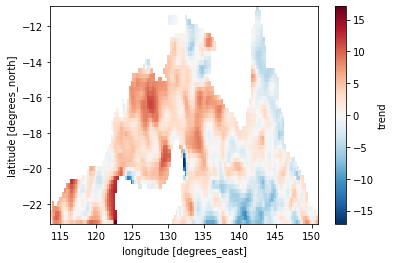

In [68]:
trend_percent_sum.trend.plot()

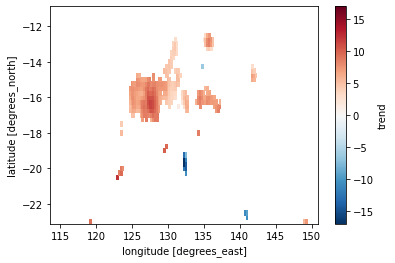

In [69]:
trend_percent_sig_sum.trend.plot()

In [70]:
# Removign the points outside of a range that is too big
def max_filter(data, vmax):
    data = data.where(data.trend < vmax, vmax - 0.01)
    data = data.where(data.trend > -vmax, -vmax + 0.01)
    
    from miscellaneous import apply_masks
    data = apply_masks(data)
    
    return data

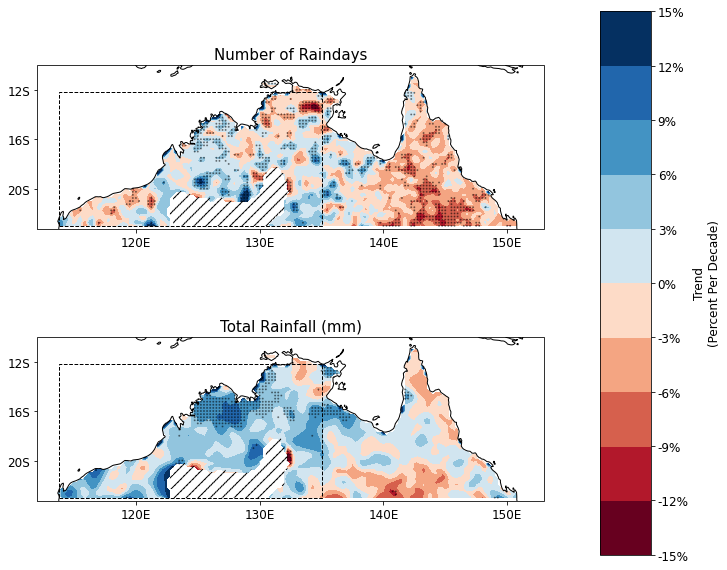

In [72]:
# fig  = plt.figure(figsize = (10,10))
# gs = gridspec.GridSpec(2,1, height_ratios = [0.1, 1], hspace = 0.1)
import plotting_functions as pf
pf = reload(pf)

fig, gs = pf.fig_formatter(height_ratios = [1,1], width_ratios = [1, 0.1], hspace = 0.0, wspace = 0.2)

vmax = 15
step = 3

cmap, levels = pf.colorbar_creater(vmax, step)

ax = fig.add_subplot(gs[0,0], projection = ccrs.PlateCarree())
plot = pf.map_plot_with_stippling_and_NWASquare(max_filter(trend_percent_count, vmax)['trend'], ax, cmap, levels
                                            , square = 1,
                                             stip_data = trend_percent_sig_count.trend, sig_alpha = 0.4
                                            )
ax.set_title('Number of Raindays', size = 15);

cax = plt.subplot(gs[:,1])
ticks = np.core.defchararray.add(levels.astype(str)  , np.tile('%',len(levels)))
pf.create_colorbar(plot, cax, levels, 
                   ticks = ticks,
                   cbar_title =  "Trend\n(Percent Per Decade)",
                  cbar_titleSize = 12, orientation = 'vertical', rotation = 0)

cmap, levels = pf.colorbar_creater(vmax, step)

ax = fig.add_subplot(gs[1,0], projection = ccrs.PlateCarree())
plot = pf.map_plot_with_stippling_and_NWASquare(max_filter(trend_percent_sum, vmax)['trend'], ax, cmap, levels
                                            , square = 1,
                                             stip_data = trend_percent_sig_sum.trend, sig_alpha = 0.4
                                            )
ax.set_title('Total Rainfall (mm)', size = 15);

# fig.savefig('../images/mjo_and_rainfall_trend_images/rainfall_trends.png', dpi = 600)

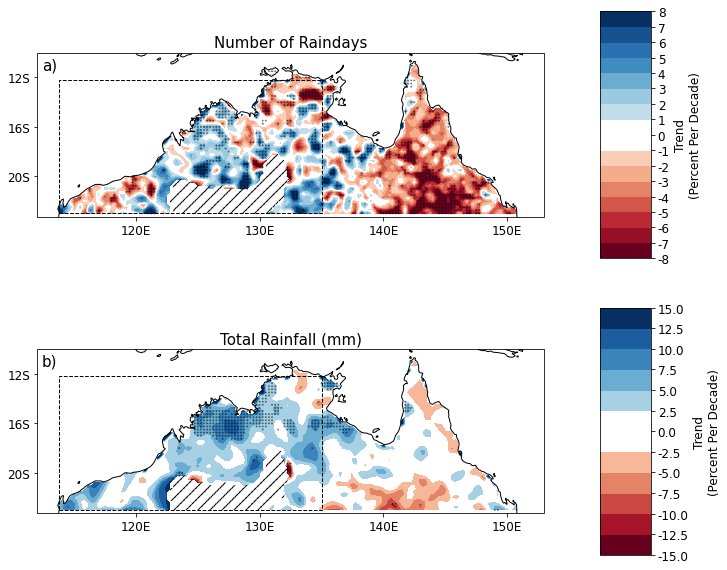

In [96]:
# fig  = plt.figure(figsize = (10,10))
# gs = gridspec.GridSpec(2,1, height_ratios = [0.1, 1], hspace = 0.1)
import plotting_functions as pf
pf = reload(pf)

fig, gs = pf.fig_formatter(height_ratios = [1,1], width_ratios = [1, 0.1], hspace = 0.2, wspace = 0.2)

vmax = 8
step = 1

cmap, levels = pf.colorbar_creater(vmax, step, add_white = 1)

ax = fig.add_subplot(gs[0,0], projection = ccrs.PlateCarree())
plot = pf.map_plot_with_stippling_and_NWASquare(max_filter(trend_percent_count, vmax)['trend'], ax, cmap, levels
                                            , square = 1,
                                             stip_data = trend_percent_sig_count.trend, sig_alpha = 0.4
                                            )
ax.set_title('Number of Raindays', size = 15);

ax.annotate('a)', xy = (0.01,0.9), xycoords = 'axes fraction', size = 15)


cax = plt.subplot(gs[0,1])
ticks = levels # np.tile('%',len(levels))
# ticks = np.core.defchararray.add(levels.astype(str)  ,ticks = np.round(levels,1))
pf.create_colorbar(plot, cax, levels, 
                   ticks = ticks,
                   cbar_title =  "Trend\n(Percent Per Decade)",
                  cbar_titleSize = 12, orientation = 'vertical', rotation = 0)

#####################################


vmax = 15
step = 2.5

cmap, levels = pf.colorbar_creater(vmax, step, add_white = 1)


ax = fig.add_subplot(gs[1,0], projection = ccrs.PlateCarree())
plot = pf.map_plot_with_stippling_and_NWASquare(max_filter(trend_percent_sum, vmax)['trend'], ax, cmap, levels
                                            , square = 1,
                                             stip_data = trend_percent_sig_sum.trend, sig_alpha = 0.4
                                            )
ax.set_title('Total Rainfall (mm)', size = 15);
ax.annotate('b)', xy = (0.01,0.9), xycoords = 'axes fraction', size = 15)

cax = plt.subplot(gs[1,1])
ticks = levels #np.tile('%',len(levels))
# ticks = np.core.defchararray.add(levels.astype(str)  ,ticks = np.round(levels,1))
pf.create_colorbar(plot, cax, levels, 
                   ticks = ticks,
                   cbar_title =  "Trend\n(Percent Per Decade)",
                  cbar_titleSize = 12, orientation = 'vertical', rotation = 0)


fig.savefig('../images/mjo_and_rainfall_trend_images/rainfall_trends_two_cbar_dense_ticks.png', dpi = 600
           ,bbox_inches = 'tight', pad = 0)